# ТЕМА 2. 

Событийно-ориентированное программирование.

## Лекция. 
Работа с многопоточностью и многопроцессорностью в Qt

## Учебные вопросы



0. processEvents
1. QTimer
2. QThread

## Источники

* Официальная документация: https://doc.qt.io/qtforpython

* Прохоренок Н. А., Дронов В. А. Python 3 и PyQt 5. Разработка приложений. 2019 г. 

# Введение

**Распространенной** проблемой при создании приложений с графическим интерфейсом является "блокировка" интерфейса при попытке выполнения длительных фоновых задач. 

Приложения с графическим пользовательским интерфейсом имеют основной поток выполнения, который запускает цикл событий и GUI. 

Если вы запустите **длительную** задачу в этом потоке, ваш графический интерфейс **зависнет**, пока задача не завершится. 

В течение этого времени пользователь не сможет взаимодействовать с приложением, что является негативной стороной использования вашего приложения. 

К счастью, Qt предоставляет различные инструменты, которые позволяют обойти эту проблему.

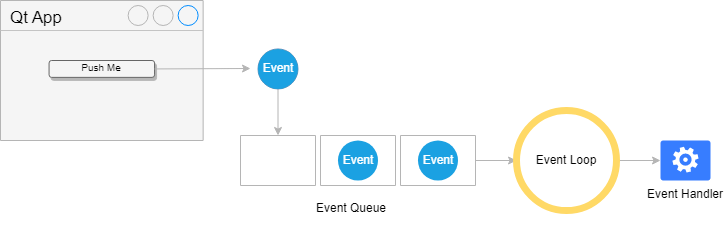

Существует два основных подхода к выполнению независимых задач: потоки и процессы.

**Потоки** совместно используют одно и то же пространство памяти, поэтому быстро запускаются и потребляют минимальные ресурсы. 

Общая память упрощает передачу данных между потоками, однако чтение / запись памяти из разных потоков может привести к условиям гонки ([Состояние гонки](https://ru.wikipedia.org/wiki/Состояние_гонки)) или сбоям. 

Поток - это отдельный поток выполнения. В большинстве операционных систем поток является компонентом процесса, и процессы могут иметь несколько потоков, выполняющихся одновременно. Каждый процесс представляет собой экземпляр программы или приложения, которое в данный момент выполняется в данной компьютерной системе.

Приложения Qt могут иметь два разных типа потоков:

* Основной поток
* Рабочие потоки

Широкий спектр приложений может извлечь выгоду из использования многопоточного программирования по крайней мере тремя способами:

1. Ускорение работы приложений за счет использования преимуществ многоядерных процессоров.

2. Упрощение структуры приложения путем разделения его на более мелкие подзадачи.

3. Поддержка адаптивности и отзывчивости вашего приложения, посредством выноса длительных задач в рабочие потоки

В графическом интерфейсе Qt на Python существует дополнительная проблема, связанная с тем, что несколько потоков связаны одной и той же глобальной блокировкой интерпретатора (GIL), это означает, что код на Python, не блокируется GIL и может выполняться только в одном потоке одновременно. 

Но это не является серьезной проблемой для PySide, где большая часть времени проводится за пределами Python.

**Процессы** используют отдельное пространство памяти (и совершенно отдельный интерпретатор Python). Это устраняет любые потенциальные проблемы с GIL, но платить за это приходится  более медленным временем запуска, большими затратами памяти и сложностью отправки/получения данных.

Для простоты обычно имеет смысл использовать потоки, если у вас нет веских причин для использования процессов. Процессы в Qt лучше подходят для запуска и взаимодействия с внешними программами.

Также ничто не мешает вам использовать потоковую обработку на чистом Python или подходы, основанные на процессах, в вашем приложении.

# 0. processEvents

Когда интерфейс выглядит **"замороженным"**, это значит, что основной цикл событий Qt блокируется из-за обработки длительного процесса, который **"перехватывает"** использование основного цикла. 

```python
"""
Демонстрация 'зависания' приложения при долгом выполнении слота
"""

import time

from PySide6 import QtWidgets


class Window(QtWidgets.QWidget):

    def __init__(self, parent=None):
        super().__init__(parent)

        self.initUi()
        self.initSignals()

    def initUi(self) -> None:
        """
        Доинициализация Ui

        :return: None
        """

        layout = QtWidgets.QVBoxLayout()

        self.label = QtWidgets.QLabel("Отсчёт идёт: ")
        self.button = QtWidgets.QPushButton("Начать")

        layout.addWidget(self.label)
        layout.addWidget(self.button)

        self.setLayout(layout)

    def initSignals(self) -> None:
        """
        Инициализация сигналов

        :return: None
        """

        self.button.pressed.connect(self.startCounter)

    def startCounter(self) -> None:
        """
        Функция отсчёта до 10 (имитация длительного выполнения функции)

        :return: None
        """

        for i in range(10):
            time.sleep(1)
            self.label.setText(f"Отсчёт идёт: {i} сек.")


if __name__ == '__main__':
    app = QtWidgets.QApplication()
    window = Window()
    window.show()
    app.exec()
```

Ваши клики и остальные действия с интерфейсом по-прежнему регистрируются ОС хоста и отправляются в ваше приложение, но поскольку основной цикл приложения **"перехвачен" долгой** функцией, то он не может принимать или реагировать на них. 

Для реагирования на действия пользователя необходимо подождать, пока ваш код не передаст управление обратно циклу Qt.

Самый простой и, возможно, самый логичный способ обойти эту проблему - принимать события из вашего кода. 

Это позволяет Qt продолжать реагировать на ОС хоста, и приложение может оставаться  отзывчивым к действиям пользователя. 

Сделать это легко, используя статический метод `QApplication.processEvents()`. Просто добавьте данную строку, в долго работающем блоке кода:

```python
"""
Демонстрация 'зависания' приложения при долгом выполнении слота
"""

import time

from PySide6 import QtWidgets


class Window(QtWidgets.QWidget):

    def __init__(self, parent=None):
        super().__init__(parent)

        self.initUi()
        self.initSignals()

    def initUi(self) -> None:
        """
        Доинициализация Ui

        :return: None
        """

        self.setFixedSize(200, 100)

        layout = QtWidgets.QVBoxLayout()

        self.label = QtWidgets.QLabel("Отсчёт идёт: ")
        self.button = QtWidgets.QPushButton("Начать")

        layout.addWidget(self.label)
        layout.addWidget(self.button)

        self.setLayout(layout)

    def initSignals(self) -> None:
        """
        Инициализация сигналов

        :return: None
        """

        self.button.pressed.connect(self.startCounter)

    def startCounter(self) -> None:
        """
        Функция отсчёта до 10 (имитация длительного выполнения функции)

        :return: None
        """

        for i in range(1, 11):
            time.sleep(1)
            self.label.setText(f"Отсчёт идёт: {i} сек.")
            QtWidgets.QApplication.processEvents()  # Добавляем нужную строчку


if __name__ == '__main__':
    app = QtWidgets.QApplication()
    window = Window()
    window.show()
    app.exec()
```

Просто? Но **НЕПРАВИЛЬНО**!

Теперь, при нажатии на кнопку "Начать", ваш код работает **без зависаний**. 

Теперь `QApplication.processEvents()` периодически передает управление обратно основному циклу событий Qt и позволяет ему реагировать на события как обычно. 

Qt принимает события и обработывает их, перед тем как вернется к выполнению оставшейся части **долгого** кода.



Это работает, но это **НЕПРАВИЛЬНО** по нескольким причинам.

* **Во-первых**:

    когда управление передается обратно в Qt, ваш код больше не выполняется. Это означает, что любая длительная работа, которую вы пытаетесь выполнить, займет больше времени. Это определенно не то, что необходимо.

* **Во-вторых**:
    
    обработка событий вне основного цикла событий (`app.exec()`) приводит к тому, что ваше приложение переходит к обработке кода (например, для запущенных слотов или событий) внутри вашего цикла. Это может привести к неопределенному поведению. 
    
    Приведенный ниже код демонстрирует это в действии:

```python
"""
Демонстрация коллизии в приложении при использовании processEvents()
"""

import time

from PySide6 import QtWidgets


class Window(QtWidgets.QWidget):

    def __init__(self, parent=None):
        super().__init__(parent)

        self.initUi()
        self.initSignals()

    def initUi(self) -> None:
        """
        Доинициализация Ui

        :return: None
        """

        self.setFixedSize(200, 100)

        layout = QtWidgets.QVBoxLayout()

        self.label = QtWidgets.QLabel("Отсчёт идёт: ")
        self.button = QtWidgets.QPushButton("Начать")
        self.buttonCollision = QtWidgets.QPushButton("Помешать")

        layout.addWidget(self.label)
        layout.addWidget(self.button)
        layout.addWidget(self.buttonCollision)

        self.setLayout(layout)

    def initSignals(self) -> None:
        """
        Инициализация сигналов

        :return: None
        """

        self.button.clicked.connect(self.startCounter)
        self.buttonCollision.clicked.connect(lambda: self.label.setText("Я вклинилась в основной поток"))

    def startCounter(self) -> None:
        """
        Функция отсчёта до 10 (имитация длительного выполнения функции)

        :return: None
        """

        for i in range(1, 11):
            time.sleep(1)
            self.label.setText(f"Отсчёт идёт: {i} сек.")
            QtWidgets.QApplication.processEvents()


if __name__ == '__main__':
    app = QtWidgets.QApplication()
    window = Window()
    window.show()
    app.exec()
```

> **Резюме:**

Использовать `processEvents()` можно, но не нужно

# 1. QTimer

Если в приложении необходимо периодически выполнять некоторые слоты или наоборот выполнять их с задержкой, то можно использовать класс **QTimer**.

Таймер - это своего рода функция, которая фоном ожидает определенное время, а затем отправляет сигнал для активации чего-либо, обычно слота.

Т.е. когда основной цикл получает сигнал тайм-аута от таймера, он останавливает этот таймер и вызывает необходимый слот. Далее таймер или удаляется или начинает отсчёт заново, в зависимости от настроек.

Использование этого класса **не является решением проблемы с зависанием** приложения, когда выполняется долгий слот, но уже позволяет немного оживить интерфейс приложения.


Класс QTimer позволяет создавать

* цифровые часы, 
* счетчики времени, 
* индикатор выполнения 
* и многое другое. 

Объект класса QTimer создается как дочерний элемент виджета. Когда виджет удаляется, объект таймера также удаляется. 

Класс QTimer предоставляет статическую функцию, называемую singleShot (), которую можно использовать для вызова функции после определенного периода.

**Методы QTimer**

| Способ | Описание |
| --- | --- |
|interval() | Возвращает интервал времени, установленный для таймера в миллисекундах.|
|isActive() | Возвращает значение True или False в зависимости от того, активен таймер или нет.|
|remainingTime() | Возвращает (в миллисекундах) время, оставшееся до следующего вызова таймера.|
|start(time) | Используется для запуска таймера. Принимает в качестве аргумента интервал для таймера.|
|stop() | Используется для завершения / остановки таймера.|
|setSingleShot(bool) | Установка значения Single Shot в значение True приведет к тому, что таймер будет запущен только один раз.|
|isSingleShot() | Возвращает значение True или False в зависимости от того, включен режим Single Shot или нет.|

Простейшая реализация QTimer, когда параллельно с основным циклом идёт постоянный вызов слота отображения текущего времени:

```python
"""
Простейшее использование класса QTimer
"""

from PySide6 import QtWidgets, QtCore


class Window(QtWidgets.QWidget):
    def __init__(self, parent=None):
        super().__init__(parent)

        self.initUi()
        self.initTimers()
        self.initSignals()

    def initUi(self) -> None:
        """
        Инициализация Ui

        :return: None
        """

        self.labelTime = QtWidgets.QLabel()
        self.labelTime.setAlignment(QtCore.Qt.AlignmentFlag.AlignCenter)

        layout = QtWidgets.QVBoxLayout()
        layout.addWidget(self.labelTime)
        layout.addWidget(QtWidgets.QPlainTextEdit())

        self.setLayout(layout)

        self.showTime()

    def initTimers(self) -> None:
        """
        Инициализация таймеров

        :return: None
        """

        self.timeTimer = QtCore.QTimer()
        self.timeTimer.setInterval(1000)
        self.timeTimer.start()

    def initSignals(self) -> None:
        """
        Инициализация сигналов

        :return: None
        """

        self.timeTimer.timeout.connect(self.showTime)

    def showTime(self) -> None:
        """
        Слот для отображения в labelTime текущего времени

        :return: None
        """

        time = QtCore.QDateTime.currentDateTime()
        timeDisplay = time.toString('yyyy-MM-dd hh:mm:ss dddd')
        self.labelTime.setText(timeDisplay)


if __name__ == '__main__':
    app = QtWidgets.QApplication()
    window = Window()
    window.show()
    app.exec()

```

> **Резюме:**

Использовать `QTimer` можно, когда необходим периодический (или с задержкой) вызов "легковесных" слотов "параллельно" основному циклу. 

**Полноценным решением с зависанием** интерфейса при долгой работе слотов **НЕ ЯВЛЯЕТСЯ**.

# 2. QThread

## **threading**



Когда дело доходит до работы с потоками в Python, вы обнаружите, что стандартная библиотека Python предлагает согласованное и надежное решение - модуль threading. 

Этот модуль предоставляет высокоуровневый API для выполнения многопоточного программирования на Python.

Вы вполнеможете использовать **threading** в своих обычных приложениях на Python. Однако, если вы используете Qt для создания приложений с графическим интерфейсом, можем воспользоваться предоставленным Qt вариантом. 

Qt предлагает полный, полностью интегрированный высокоуровневый API для выполнения многопоточности.



**Зачем использовать потоки Qt, если есть threading?**

Например, при создании приложения с графическим интерфейсом, которое дополнительно будет иметь веб-версию, потоки Python могут иметь больше смысла, потому что ваш сервер вообще не будет зависеть от Qt. 

**НО**, если вы создаете "голые" приложения Qt, тогда потоки Qt для вас.

Использование поддержки потоков PyQt обеспечивает следующие преимущества:

1. Классы, связанные с потоками, полностью интегрированы с остальной инфраструктурой PyQt.

2. Рабочие потоки могут иметь свой собственный цикл событий, который позволяет обрабатывать события.

3. Межпоточная связь возможна с использованием 
сигналов и слотов.

Можно использовать гибраидные варианты, когда часть задач решается с использованием threading и часть задач с помощью потоков Qt.

## **QThread** 

### Описание

Класс QThread обычно используется для выноса задач в отдельные потоки, чтобы увеличить скорость приложения с графическим интерфейсом, поскольку большое количество задач в одном потоке делает приложение медленным и зависшим. 

QThread сам по себе не является потоком. Это оболочка вокруг потока операционной системы. Объект **"реального потока"** создается при вызове метода `.start().`

Вы можете создать столько рабочих потоков (потоков QThread), сколько вам нужно в приложении. 

Каждый поток может иметь свой собственный цикл событий и поддерживать механизм сигналов и слотов PyQt для связи с основным потоком.



Наибольшим преимуществом между классом  QThread и модулем Python threading из стандартной библиотеки является поддержка отправки и передачи сигналов. 

Эти сигналы могут быть строкой с текстом, списками с переменными, кортежами, целыми числами и другими типами python. Вы можете изменять цвет этих приложений, вставлять, устанавливать или добавлять тексты, рисовать, рисовать и иметь множество других функций для быстрого и гибкого создания приложений с графическим интерфейсом.



QThread предоставляет высокоуровневый интерфейс прикладного программирования (API) для управления потоками. 

Этот API включает в себя:

* сигналы:
    * **.started()** - сигнал при запуске потока
    * **.finished()** - сигнал при завершении потока

* методы и слоты:
    * **.start()** - запуск потока
    * **.isFinished()** - проверка, был ли поток остановлен
    * **.isRunning()** - проверка, был ли поток запущен


### Использование

Согласно документации, существует два основных способа создания рабочих потоков с QThread:


**Первый способ**

1. Создайте класс `Worker` **(имя может быть другим)**  унаследовавшись от класса `QObject`.
2. Создайте (переопределите) метод `.run()` в классе `Worker`. Реализация `.run()` должна содержать все необходимые функциональные возможности для выполнения конкретной задачи (ваш код, который должен выполняться в отдельном потоке).
3. В основном коде создайте экземпляр класса `QThread` (прим.: `thread`).
4. В основном коде cоздайте экземпляр класса `Worker` (прим.: `worker`)
5. Вызовите у экземпляра `worker` метод `.moveToThread(thread)`, используя `thread` в качестве аргумента. 

Создание экземпляра QThread обеспечивает параллельный цикл событий. Цикл событий позволяет объектам, принадлежащим потоку, получать сигналы на свои слоты, и эти слоты будут выполняться внутри потока.



```python
"""
Использование потока через класс наследованный от QObject
"""

import time

from PySide6 import QtCore, QtWidgets


class Worker(QtCore.QObject):
    finished = QtCore.Signal()
    progress = QtCore.Signal(int)

    def run(self) -> None:
        """
        Метод имитирующий долгую задачу

        :return: None
        """

        for i in range(5):
            time.sleep(1)
            self.progress.emit(i + 1)
        self.finished.emit()


class Window(QtWidgets.QWidget):
    def __init__(self, parent=None):
        super(Window, self).__init__(parent)

        self.initThreads()
        self.initUi()
        self.initSignals()

    def initUi(self) -> None:
        """
        Инициализация Ui

        :return: None
        """

        self.label = QtWidgets.QLabel("Выполнение долгой задачи: ")
        self.pushButton = QtWidgets.QPushButton("Запустить долгую задачу")
        self.pushButtonOtherProcess = QtWidgets.QPushButton("Другие действия с GUI")
        self.plainTextEdit = QtWidgets.QPlainTextEdit()

        layout = QtWidgets.QVBoxLayout()
        layout.addWidget(self.label)
        layout.addWidget(self.pushButton)
        layout.addWidget(self.pushButtonOtherProcess)
        layout.addWidget(self.plainTextEdit)

        self.setLayout(layout)

    def initThreads(self) -> None:
        """
        Инициализация потоков

        :return: None
        """

        self.thread = QtCore.QThread()
        self.worker = Worker()
        self.worker.moveToThread(self.thread)

    def initSignals(self) -> None:
        """
        Инициализация сигналов

        :return: None
        """

        self.pushButton.clicked.connect(self.runLongProcess)
        self.pushButtonOtherProcess.clicked.connect(
            lambda: self.plainTextEdit.appendPlainText(f"{time.ctime()}: push clicked")
        )

        self.thread.started.connect(self.worker.run)
        self.thread.finished.connect(self.thread.deleteLater)
        self.thread.finished.connect(lambda: self.pushButton.setEnabled(True))

        self.worker.finished.connect(self.thread.quit)
        self.worker.finished.connect(self.worker.deleteLater)
        self.worker.progress.connect(self.reportProgress)

    def runLongProcess(self) -> None:
        """
        Запуск потока с "долгим" выполнением

        :return: None
        """

        self.pushButton.setEnabled(False)
        self.thread.start()

    def reportProgress(self, progress) -> None:
        """
        Приём данных из потока и обработка их в основном цикле приложения

        :param progress: прогресс выполнения функции в потоке
        :return: None
        """

        self.label.setText(f"Выполнение долгой задачи: {progress}")


if __name__ == '__main__':
    app = QtWidgets.QApplication()

    window = Window()
    window.show()

    app.exec()

```

**Второй способ**
1. Создайте класс `Worker` унаследовавшись от класса `QThread`
2. Переопределите в классе `Worker` метод `.run()` (поместите туда код, который необходимо выполнить в отдельном потоке)
3. Создайте в основном коде экземпляр класса `Worker` (прим.: `worker`)
4. Запустите код в отдельном потоке.

```python
"""
Использование потока через класс наследованный от QThread
"""

import time

from PySide6 import QtCore, QtWidgets


class Worker(QtCore.QThread):
    progress = QtCore.Signal(int)

    def run(self) -> None:
        """
        Метод имитирующий долгую задачу

        :return: None
        """

        for i in range(5):
            time.sleep(1)
            self.progress.emit(i + 1)
        self.finished.emit()


class Window(QtWidgets.QWidget):
    def __init__(self, parent=None):
        super(Window, self).__init__(parent)

        self.initThreads()
        self.initUi()
        self.initSignals()

    def initUi(self) -> None:
        """
        Инициализация Ui

        :return: None
        """

        self.label = QtWidgets.QLabel("Выполнение долгой задачи: ")
        self.pushButton = QtWidgets.QPushButton("Запустить долгую задачу")
        self.pushButtonOtherProcess = QtWidgets.QPushButton("Другие действия с GUI")
        self.plainTextEdit = QtWidgets.QPlainTextEdit()

        layout = QtWidgets.QVBoxLayout()
        layout.addWidget(self.label)
        layout.addWidget(self.pushButton)
        layout.addWidget(self.pushButtonOtherProcess)
        layout.addWidget(self.plainTextEdit)

        self.setLayout(layout)

    def initThreads(self) -> None:
        """
        Инициализация потоков

        :return: None
        """

        self.thread = Worker()

    def initSignals(self) -> None:
        """
        Инициализация сигналов

        :return: None
        """

        self.pushButton.clicked.connect(self.runLongProcess)
        self.pushButtonOtherProcess.clicked.connect(
            lambda: self.plainTextEdit.appendPlainText(f"{time.ctime()}: push clicked")
        )

        self.thread.progress.connect(self.reportProgress)
        self.thread.finished.connect(self.thread.deleteLater)
        self.thread.finished.connect(lambda: self.pushButton.setEnabled(True))


    def runLongProcess(self) -> None:
        """
        Запуск потока с "долгим" выполнением

        :return: None
        """

        self.pushButton.setEnabled(False)
        self.thread.start()

    def reportProgress(self, progress) -> None:
        """
        Приём данных из потока и обработка их в основном цикле приложения

        :param progress: прогресс выполнения функции в потоке
        :return: None
        """

        self.label.setText(f"Выполнение долгой задачи: {progress}")


if __name__ == '__main__':
    app = QtWidgets.QApplication()

    window = Window()
    window.show()

    app.exec()
```